# 4. Сверточные нейронные сети.


## 1. Классификация предметов одежды (датасет Fashion MNIST)



### 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

импорт библиотек и набор данных

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from torchvision import models

%matplotlib inline

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the testing data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Функция по показу изображения

Были заимствованы из документаций 

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    elif version == "CIFAR-10":
        ax2.set_yticklabels(["airplane",
                            "automobile",
                            "bird",
                            "cat",
                            "deer",
                            "dog",
                            "frog",
                            "horse",
                            "ship",
                            "truck",], size='small');
        
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Пример изображения

''

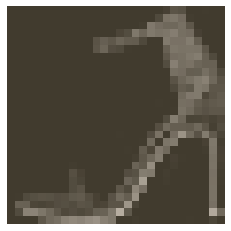

In [ ]:
image, label = next(iter(trainloader))
imshow(image[0,:])
""

Предложенная модель

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

Количество ее параметров

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

242762

Обучение модели

In [ ]:

epochs = 8
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for test_images, test_labels in testloader:
                test_images = test_images.view(test_images.shape[0], -1)
                logps = model(test_images)
                test_loss += criterion(logps, test_labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == test_labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch {}/{}..".format(e+1, epochs),
              "Training loss: {:.3f}..".format(train_losses[-1]),
              "Test loss: {:.3f}..".format(test_losses[-1]),
              "Test Accuracy: {:.3f}%".format(accuracy/len(testloader)))


Epoch 1/8.. Training loss: 0.516.. Test loss: 0.454.. Test Accuracy: 0.831%
Epoch 2/8.. Training loss: 0.390.. Test loss: 0.436.. Test Accuracy: 0.837%
Epoch 3/8.. Training loss: 0.357.. Test loss: 0.417.. Test Accuracy: 0.851%
Epoch 4/8.. Training loss: 0.334.. Test loss: 0.401.. Test Accuracy: 0.860%
Epoch 5/8.. Training loss: 0.316.. Test loss: 0.397.. Test Accuracy: 0.861%
Epoch 6/8.. Training loss: 0.304.. Test loss: 0.370.. Test Accuracy: 0.867%
Epoch 7/8.. Training loss: 0.294.. Test loss: 0.354.. Test Accuracy: 0.873%
Epoch 8/8.. Training loss: 0.282.. Test loss: 0.372.. Test Accuracy: 0.872%


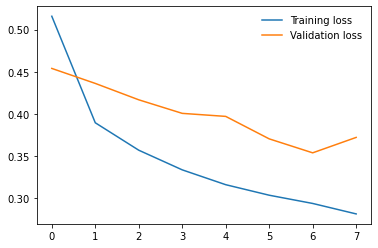

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

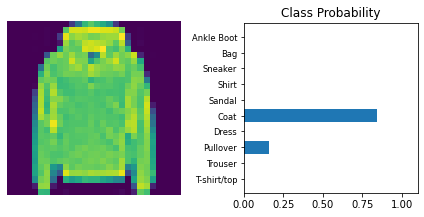

In [ ]:

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')

In [ ]:
test_loss = 0
accuracy = 0
# Turn off gradients for validation, saves memory and computations
predict = []
true_label = []

with torch.no_grad():
    for test_images, test_labels in testloader:
        test_images = test_images.view(test_images.shape[0], -1)
        logps = model(test_images)
        test_loss += criterion(logps, test_labels)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        predict.append(top_class)
        true_label.append(test_labels.view(*top_class.shape))


In [ ]:
torch.vstack(predict).flatten().shape,torch.vstack(true_label).flatten().shape

(torch.Size([10000]), torch.Size([10000]))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(torch.vstack(true_label).flatten().numpy(), torch.vstack(predict).flatten().numpy())
print(conf_mat)


[[832   0  15  26   3   2 115   0   7   0]
 [  3 957   2  32   2   0   4   0   0   0]
 [ 19   1 795  15  86   0  80   0   4   0]
 [ 24   4   8 905  33   0  22   0   4   0]
 [  0   0 113  38 789   0  59   0   1   0]
 [  0   0   0   1   0 958   0  30   0  11]
 [128   0  81  32  72   0 678   0   9   0]
 [  0   0   0   0   0  29   0 966   0   5]
 [ 10   0   5  10   4   9  12   5 945   0]
 [  1   0   0   0   0   9   0  91   0 899]]


названия классов

взяты из описания датасета

In [ ]:

class_names =     ['T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot']

Text(0.5, 15.0, 'Predicted label')

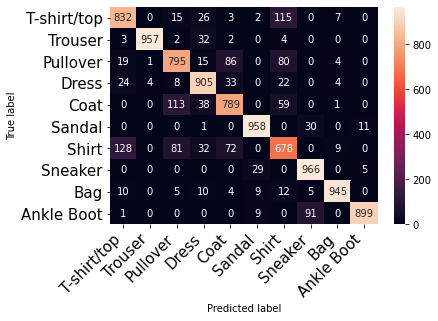

In [ ]:
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
torch.save(model.state_dict(), 'checkpoint1.pth')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

 Возьмем resnet18

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet18(pretrained=False)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        model.fc = nn.Linear(512, 10)
        self.model = model
    
    def forward(self, data):
        # print(data.shape)
        out = self.model(data.reshape((data.shape[0],1,28,28)))
        return out

In [ ]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

d:\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11175434

 нужно дождаться больше 2-3 эпох - точность будет 90+

In [ ]:
epochs = 5
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    
    pbar = tqdm(trainloader) #загрузка
    for images, labels in pbar:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for test_images, test_labels in testloader:
                test_images = test_images.view(test_images.shape[0], -1)
                logps = model(test_images)
                test_loss += criterion(logps, test_labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == test_labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch {}/{}..".format(e+1, epochs),
              "Training loss: {:.3f}..".format(train_losses[-1]),
              "Test loss: {:.3f}..".format(test_losses[-1]),
              "Test Accuracy: {:.3f}%".format(accuracy/len(testloader)))



Epoch 1/5.. Training loss: 0.466.. Test loss: 0.371.. Test Accuracy: 0.869%



Epoch 2/5.. Training loss: 0.328.. Test loss: 0.324.. Test Accuracy: 0.884%



Epoch 3/5.. Training loss: 0.290.. Test loss: 0.307.. Test Accuracy: 0.890%



Epoch 4/5.. Training loss: 0.258.. Test loss: 0.299.. Test Accuracy: 0.897%



Epoch 5/5.. Training loss: 0.260.. Test loss: 0.297.. Test Accuracy: 0.893%


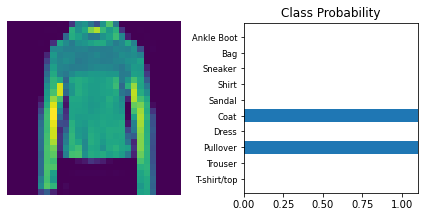

In [ ]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = output

# Plot the image and probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion')

In [ ]:
def saliency(img, model):
    # we don't need gradients weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    model.eval()
    # transoform input PIL image to torch.Tensor and normalize
    input = img
    input.unsqueeze_(0)

    # we want to calculate gradient of higest score w.r.t. input
    # set requires_grad to True for input 
    input.requires_grad = True
    # forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    # backward pass to get gradients of score predicted class for our input image
    score.backward()
    
    # get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    # normalize to [0..1]
    #slc = (slc - slc.min())/(slc.max()-slc.min())

    # apply inverse transform on image
    # with torch.no_grad():
    #     input_img = inv_normalize(input[0])

    # plot image and its saleincy map
    # plt.figure(figsize=(20, 20))
    # plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input[0].detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    return slc

<ipython-input-23-7535470f50e5>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  saliency(torch.tensor(images[0]),model)


''

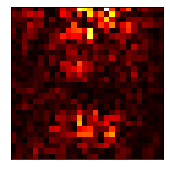

In [ ]:
saliency(torch.tensor(images[0]),model)
""

In [ ]:
torch.save(model.state_dict(), 'resnet_18_fasnion.pth')

##  2. Классификация изображений (датасет CIFAR 10) 


### 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Download and load the training data
trainset = datasets.CIFAR10('~/.pytorch/CIFAR10/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the testing data
testset = datasets.CIFAR10('~/.pytorch/CIFAR10/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

''

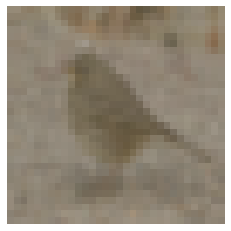

In [ ]:
image, label = next(iter(trainloader))
imshow(image[0,:])
""

Предложенная модель

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

Количество ее параметров

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

828490

Обучение модели

In [ ]:

epochs = 8
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for test_images, test_labels in testloader:
                test_images = test_images.view(test_images.shape[0], -1)
                logps = model(test_images)
                test_loss += criterion(logps, test_labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == test_labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch {}/{}..".format(e+1, epochs),
              "Training loss: {:.3f}..".format(train_losses[-1]),
              "Test loss: {:.3f}..".format(test_losses[-1]),
              "Test Accuracy: {:.3f}%".format(accuracy/len(testloader)))


Epoch 1/8.. Training loss: 1.715.. Test loss: 1.594.. Test Accuracy: 0.432%
Epoch 2/8.. Training loss: 1.532.. Test loss: 1.525.. Test Accuracy: 0.457%
Epoch 3/8.. Training loss: 1.444.. Test loss: 1.481.. Test Accuracy: 0.479%
Epoch 4/8.. Training loss: 1.375.. Test loss: 1.450.. Test Accuracy: 0.496%
Epoch 5/8.. Training loss: 1.320.. Test loss: 1.433.. Test Accuracy: 0.498%
Epoch 6/8.. Training loss: 1.270.. Test loss: 1.431.. Test Accuracy: 0.509%
Epoch 7/8.. Training loss: 1.227.. Test loss: 1.409.. Test Accuracy: 0.514%
Epoch 8/8.. Training loss: 1.187.. Test loss: 1.437.. Test Accuracy: 0.504%


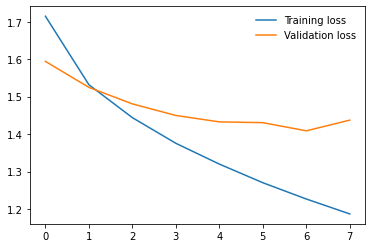

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


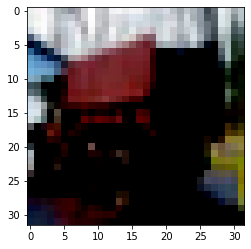

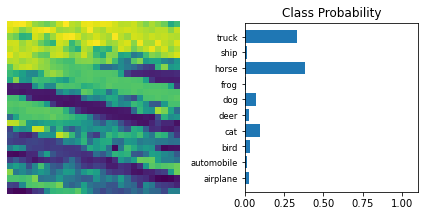

In [ ]:

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 3*32*32)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)
plt.imshow(images[0].permute(1,2,0))
# Plot the image and probabilities
view_classify(images[0], ps, version='CIFAR-10')

In [ ]:
test_loss = 0
accuracy = 0
# Turn off gradients for validation, saves memory and computations
predict = []
true_label = []

with torch.no_grad():
    for test_images, test_labels in testloader:
        test_images = test_images.view(test_images.shape[0], -1)
        logps = model(test_images)
        test_loss += criterion(logps, test_labels)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        predict.append(top_class)
        true_label.append(test_labels.view(*top_class.shape))


In [ ]:
torch.vstack(predict).flatten().shape,torch.vstack(true_label).flatten().shape

(torch.Size([10000]), torch.Size([10000]))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(torch.vstack(true_label).flatten().numpy(), torch.vstack(predict).flatten().numpy())
print(conf_mat)


[[595  22  70  31  52  16   9  14 125  66]
 [ 64 565  19  39  16   3   3  12 147 132]
 [ 90   8 400 106 177  91  26  48  29  25]
 [ 29  12  85 418  93 185  50  39  36  53]
 [ 43   4 175  95 478  44  31  76  29  25]
 [ 17   6  94 286  72 382  21  59  38  25]
 [ 15  19 124 167 160  59 399  12  33  12]
 [ 30  11  42  81 101  94  13 554  15  59]
 [108  45  15  28  40  14   2   9 686  53]
 [ 45 171  15  53  19  10   8  33  79 567]]


In [ ]:
# названия классов
# взяты из описания датасета
class_names = ["airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",]

Text(0.5, 15.0, 'Predicted label')

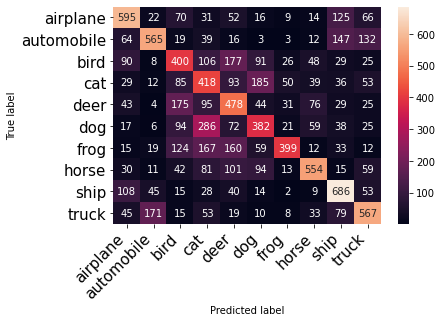

In [ ]:
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')


### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

 Возьмем  ту же сеть - resnet18

In [ ]:
from torchvision import models

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnet18(pretrained=False)
        # model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        model.fc = nn.Linear(512, 10)
        self.model = model
    
    def forward(self, data):
        # print(data.shape)
        out = self.model(data.reshape((data.shape[0],3,32,32)))
        return out

In [ ]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [ ]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11181642

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
epochs = 12
train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    
    pbar = tqdm(trainloader)
    for images, labels in pbar:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for test_images, test_labels in testloader:
                test_images = test_images.view(test_images.shape[0], -1)
                logps = model(test_images)
                test_loss += criterion(logps, test_labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == test_labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch {}/{}..".format(e+1, epochs),
              "Training loss: {:.3f}..".format(train_losses[-1]),
              "Test loss: {:.3f}..".format(test_losses[-1]),
              "Test Accuracy: {:.3f}%".format(accuracy/len(testloader)))



Epoch 1/12.. Training loss: 1.486.. Test loss: 1.201.. Test Accuracy: 0.582%



Epoch 2/12.. Training loss: 1.051.. Test loss: 0.986.. Test Accuracy: 0.661%



Epoch 3/12.. Training loss: 0.856.. Test loss: 0.824.. Test Accuracy: 0.720%



Epoch 4/12.. Training loss: 0.725.. Test loss: 0.819.. Test Accuracy: 0.712%



Epoch 5/12.. Training loss: 0.621.. Test loss: 0.781.. Test Accuracy: 0.736%


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


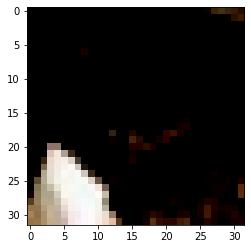

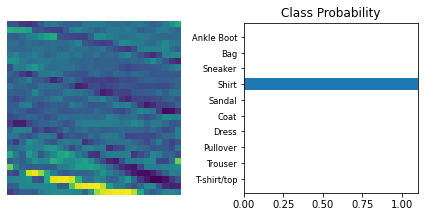

In [ ]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 3*32*32)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = output
plt.imshow(images[0].permute(1,2,0))

# Plot the image and probabilities
view_classify(img, ps, version='Fashion')

In [ ]:
def saliency(img, model):
    # we don't need gradients weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    model.eval()
    # transoform input PIL image to torch.Tensor and normalize
    input = img
    input.unsqueeze_(0)

    # we want to calculate gradient of higest score w.r.t. input
    # set requires_grad to True for input 
    input.requires_grad = True
    # forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    # backward pass to get gradients of score predicted class for our input image
    score.backward()
    
    # get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    # normalize to [0..1]
    #slc = (slc - slc.min())/(slc.max()-slc.min())

    # apply inverse transform on image
    # with torch.no_grad():
    #     input_img = inv_normalize(input[0])

    # plot image and its saleincy map
    # plt.figure(figsize=(20, 20))
    # plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input[0].detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    return slc

<ipython-input-46-7535470f50e5>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  saliency(torch.tensor(images[0]),model)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


''

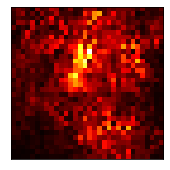

In [ ]:
saliency(torch.tensor(images[0]),model)
""

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:16<00:00, 81.74it/s]


### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)